In [1]:
import pdblp, scipy, math, twitter, seaborn as sns, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats.distributions import t
from dateutil.parser import parse
from pykalman import KalmanFilter
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
def get_data(tickers, start_date='20000101', end_date='20171231'):
    con = pdblp.BCon()
    con.start()
    data = con.bdh(tickers, 'px_last', start_date=start_date, end_date=end_date)
    con.stop()
    data = data.xs('px_last', axis=1, level=1)
    return data

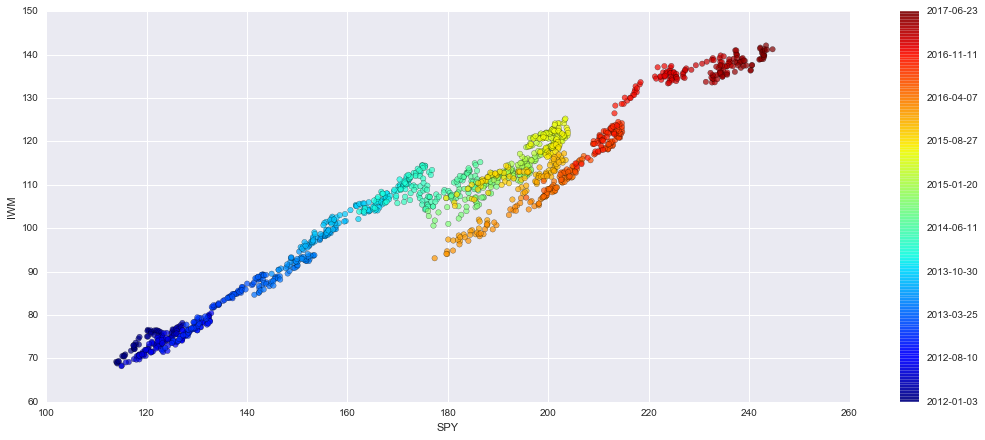

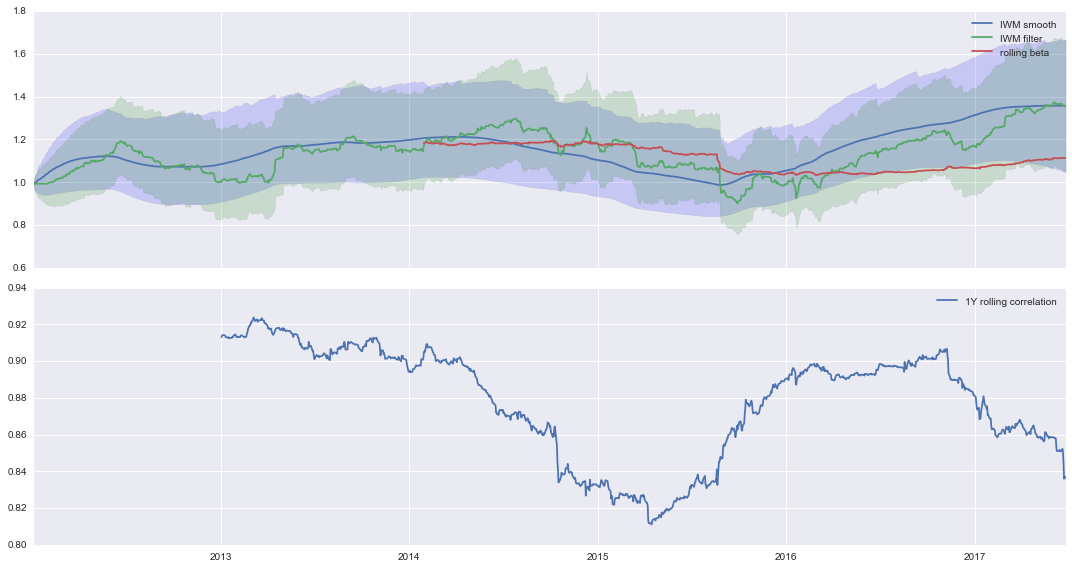

In [3]:
my_sec = 'iwm equity'
kf_type = 'smooth'      # choose kalman filter/smoothing
delta = 1e-2            # min(1.001-my_pct[['spy equity', my_sec]].corr().values[0][1], 0.99)
rb_days = int(21.67*24) # roughly 30 months

my_prices = get_data(['spy equity', 'evri equity', 'k equity'] + [my_sec], start_date='20120101', end_date='20171231')
my_prices = my_prices.dropna(how='any')
my_pct = my_prices.pct_change().dropna(how='any')

fig, ax = plt.subplots(figsize=(18,7))
sct = plt.scatter(my_prices['spy equity'], my_prices[my_sec], s=30, c=np.linspace(0.1, 1, len(my_prices)),
                  cmap=plt.get_cmap('jet'), alpha=0.7)
cbar = fig.colorbar(sct)
cbar.ax.set_yticklabels([str(p.date()) for p in my_prices.index[::len(my_prices)//9]])
plt.xlabel('SPY')
plt.ylabel(my_sec.split(' ')[0].upper());

trans_cov = delta / (1 - delta) * np.identity(2)
obs_mat = np.expand_dims(np.vstack([my_pct['spy equity'], [np.ones(len(my_pct))]]).T, axis=1)
alpha = 0.8
tval = t.ppf(1.0-alpha/2., 100)
obs_cov = my_pct[['spy equity', my_sec]].cov()['spy equity'][my_sec]
init_cov = my_pct[['spy equity', my_sec]].cov()

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[1,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=obs_cov,
                  transition_covariance=trans_cov)

# Use the observations y to get running estimates and errors for the state parameters
state_means_smooth, state_covs_smooth = getattr(kf, 'smooth', None)(my_pct[my_sec].values)
state_means_filter, state_covs_filter = getattr(kf, 'filter', None)(my_pct[my_sec].values)
sigma_smooth = state_covs_smooth[:,0,0]**0.5
sigma_filter = state_covs_filter[:,0,0]**0.5
_, axarr = plt.subplots(2, sharex=True, figsize=(15,8))
axarr[0].plot(my_pct.index, state_means_smooth[:,0], label=my_sec.split(' ')[0].upper() + ' smooth')
axarr[0].plot(my_pct.index, state_means_filter[:,0], label=my_sec.split(' ')[0].upper() + ' filter')
axarr[0].plot(my_pct.rolling(rb_days).cov().unstack()[my_sec]['spy equity'] /
              my_pct.rolling(rb_days).var()['spy equity'], label='rolling beta')
axarr[0].fill_between(my_pct.index, state_means_smooth[:,0] - sigma_smooth*tval,
                      state_means_smooth[:,0] + sigma_filter*tval, facecolor='blue', alpha=0.15)
axarr[0].fill_between(my_pct.index, state_means_filter[:,0] - sigma_smooth*tval,
                      state_means_filter[:,0] + sigma_filter*tval, facecolor='green', alpha=0.15)
axarr[0].legend()
# axarr[1].plot(my_pct.index, state_means[:,1], label='intercept')
axarr[1].plot(my_pct.rolling(250).corr().unstack()[my_sec]['spy equity'], label='1Y rolling correlation')
axarr[1].legend()
plt.tight_layout();

In [12]:
benchmark = 'spy equity'
tickers = '''msft
aapl
ibm
aa
adnt
baba
c
fb
jpm
nflx
bac
amzn
ally'''
tickers = [ticker + ' equity' for ticker in tickers.split('\n')]
names = tickers

In [168]:
ticker_table = pd.read_csv("tickers.csv")
ticker_table = ticker_table[~ticker_table.ticker.str.contains('N.A.')]
drop_names = []
chosen_names = [tk for tk in ticker_table.ticker.values if tk not in drop_names]
ticker_table = ticker_table[ticker_table.ticker.isin(chosen_names)]
tickers = [tk.lower() for tk in ticker_table['BBTicker'].values]
names = [tk for tk in ticker_table['ticker'].values]

In [5]:
my_prices = get_data(tickers + [benchmark], start_date='20050101', end_date='20171231')
my_pct = my_prices.pct_change()

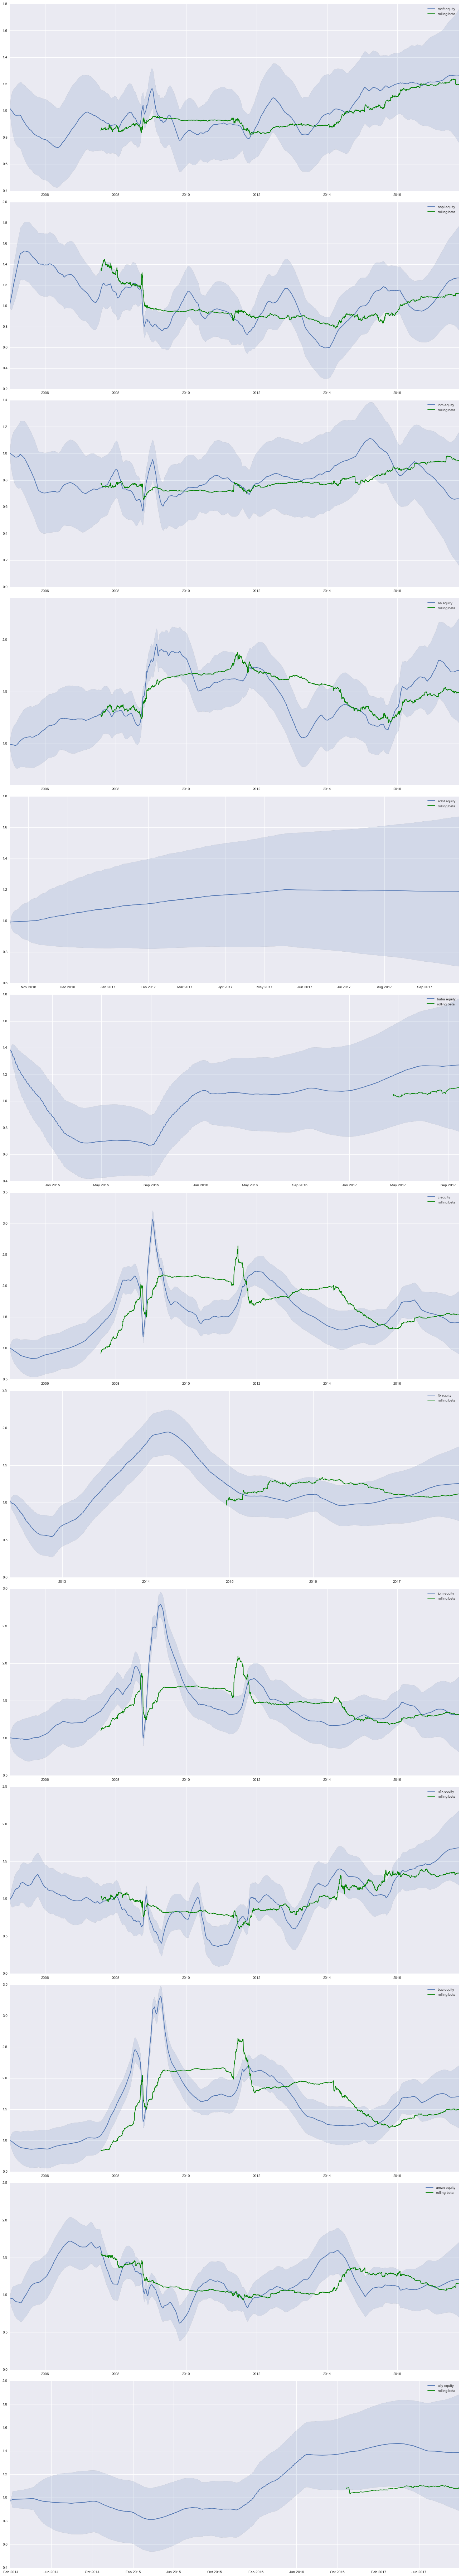

In [13]:
rb_days = int(21.67*30) # roughly 30 months
kf_type = 'smooth'      # choose kalman filter/smoothing
delta = 1e-2
trans_cov = delta / (1 - delta) * np.eye(2)
alpha = 0.7
tval = t.ppf(1.0-alpha/2., 5)
_, axarr = plt.subplots(len(tickers), figsize=(18,100))

for i, ticker in enumerate(tqdm_notebook(tickers)):
    dataset = my_pct[[ticker] + [benchmark]].dropna(how='any')
    obs_mat = np.expand_dims(np.vstack([[dataset[benchmark]], [np.ones(len(dataset))]]).T, axis=1)
    obs_cov = my_pct[[benchmark, ticker]].cov()[benchmark][ticker]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[1,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=obs_cov, #0.01,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = getattr(kf, kf_type, None)(dataset[ticker].values)
    sigmas = state_covs[:,0,0]**0.5
    axarr[i].plot(dataset.index, state_means[:,0], label=names[i])
    axarr[i].plot(dataset.index, dataset.rolling(rb_days).cov().unstack()[ticker][benchmark] /
                  dataset.rolling(rb_days).var()[benchmark], c='g', label='rolling beta')
    axarr[i].fill_between(dataset.index, state_means[:,0] - sigmas*tval, state_means[:,0] + sigmas*tval, alpha=0.15)
    axarr[i].legend()
plt.tight_layout();

In [ ]:
kf_type = 'smooth'      # choose kalman filter/smoothing
benchmark = 'spy equity'

ticker_table = pd.read_csv("tickers.csv")
ticker_table = ticker_table[~ticker_table.ticker.str.contains('N.A.')]
drop_names = []
chosen_names = [tk for tk in ticker_table.ticker.values if tk not in drop_names]
ticker_table = ticker_table[ticker_table.ticker.isin(chosen_names)]
tickers = [tk.lower() for tk in ticker_table['BBTicker'].values]
names = [tk for tk in ticker_table['ticker'].values]

my_pct = get_data(tickers + [benchmark], start_date='20060101', end_date='20171231').pct_change()
index = pd.MultiIndex.from_product([[], ['beta', 'conf']], names=['beta', 'conf'])
rb_days = int(21.67*30) # roughly 30 months
delta = 1e-2
trans_cov = delta / (1 - delta) * np.eye(2)
alpha = 0.5
tval = t.ppf(1.0-alpha/2., 5)
index = pd.MultiIndex.from_product([[], ['beta', 'conf']], names=['beta', 'conf'])
betas = pd.DataFrame(index=my_pct.index, columns=index)

for i, ticker in enumerate(tickers):
    dataset = my_pct[[ticker] + [benchmark]].dropna(how='any')
    obs_mat = np.expand_dims(np.vstack([[dataset[benchmark]], [np.ones(len(dataset))]]).T, axis=1)
    obs_cov = my_pct[[benchmark, ticker]].cov()[benchmark][ticker]
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[1,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=obs_cov,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.smooth(dataset[ticker].values)
    index = pd.MultiIndex.from_product([[ticker], ['beta', 'conf']], names=['beta', 'conf'])
    data = np.array(np.array([state_means[:,0], state_covs[:,0,0]**0.5*tval]).T)
    df_ = pd.DataFrame(data=data, index=dataset.index, columns=index)
    betas = betas.join(df_, how='outer')
last_betas = betas.ffill().xs('beta', axis=1, level=1).iloc[[-1,-5]].T
last_betas.insert(0, 'archer ticker', ticker_table['archer ticker'].values)
last_betas.to_csv('export.csv')

## Scratch code...

In [175]:
# https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
ah = pd.read_csv('Crimes_-_2001_to_present.csv')

In [261]:
ah.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [182]:
ah1 = ah.iloc[:500]

In [211]:
ah1_sub = ah1[['Year', 'Primary Type', 'Description']]

In [252]:
selected_cat = ['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'HOMICIDE',
       'INTIMIDATION', 'KIDNAPPING',
       'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'OFFENSE INVOLVING CHILDREN',
       'PROSTITUTION',
       'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'THEFT']

In [297]:
summary_tbl = ah['Date'].groupby([ah['Primary Type'], ah['Year']]).count().unstack().loc[selected_cat].sort_values(2001, ascending=False)

In [298]:
summary_tbl1 = summary_tbl.unstack().reset_index()

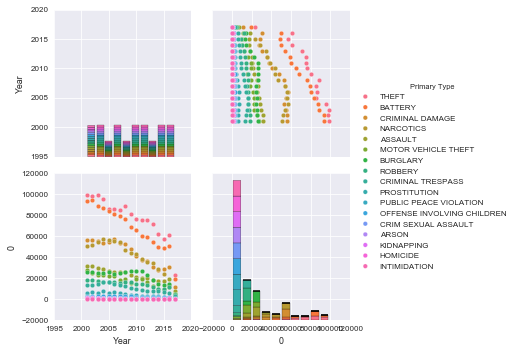

In [303]:
sns.set()
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = sns.pairplot(hue='Primary Type', data=summary_tbl1)

In [11]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

In [275]:
plt.imsave('sdf.png', a[0])

In [12]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [13]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 332s - loss: 0.3394 - acc: 0.8967 - val_loss: 0.0794 - val_acc: 0.9745
Epoch 2/12
60000/60000 [==============================] - 338s - loss: 0.1142 - acc: 0.9661 - val_loss: 0.0544 - val_acc: 0.9825
Epoch 3/12
60000/60000 [==============================] - 347s - loss: 0.0863 - acc: 0.9745 - val_loss: 0.0460 - val_acc: 0.9852
Epoch 4/12
60000/60000 [==============================] - 349s - loss: 0.0707 - acc: 0.9788 - val_loss: 0.0411 - val_acc: 0.9872
Epoch 5/12
60000/60000 [==============================] - 362s - loss: 0.0634 - acc: 0.9810 - val_loss: 0.0349 - val_acc: 0.9890
Epoch 6/12
60000/60000 [==============================] - 363s - loss: 0.0562 - acc: 0.9833 - val_loss: 0.0332 - val_acc: 0.9894
Epoch 7/12
60000/60000 [==============================] - 366s - loss: 0.0507 - acc: 0.9847 - val_loss: 0.0323 - val_acc: 0.9895
Epoch 8/12
60000/60000 [=======================

In [440]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.029052104907
Test accuracy: 0.9915


In [19]:
import pickle

In [439]:
mdl.save('mnist_modelasdf.h5')

OSError: Unable to create file (Unable to truncate a file which is already open)

In [422]:
with open('mnist_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [411]:
with open('mnist_model.pkl', 'rb') as f:
    mdl = pickle.load(f)

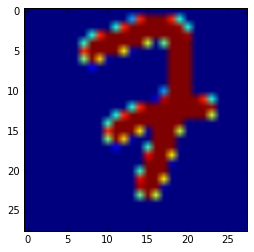

1/1 [==============================] - 0s


3

In [444]:
from PIL import Image
digit = Image.open('digit.png').convert('L')
digit = np.array(digit)
digit = np.invert(digit)
plt.imshow(digit)
plt.show()

if K.image_data_format() == 'channels_first':
    x_predict = digit.reshape(1, 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_predict = digit.reshape(1, img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_predict = x_predict.astype('float32')
# x_predict /= 255
mdl.predict_classes(x_predict)[0]

In [7]:
import numpy as np
import pylab as pl

from pykalman.datasets import load_robot
from pykalman import KalmanFilter

# Load data and initialize Kalman Filter
data = load_robot()
kf = KalmanFilter(
    data.transition_matrix,
    data.observation_matrix,
    data.initial_transition_covariance,
    data.initial_observation_covariance,
    data.transition_offsets,
    data.observation_offset,
    data.initial_state_mean,
    data.initial_state_covariance,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
      'observation_offsets', 'initial_state_mean',
      'initial_state_covariance'
    ]
)


In [15]:
# Learn good values for parameters named in `em_vars` using the EM algorithm
loglikelihoods = np.zeros(10)
for i in range(len(loglikelihoods)):
    kf = kf.em(X=data.observations, n_iter=1)
#     loglikelihoods[i] = kf.loglikelihood(data.observations)

In [16]:
n_dim_state = data.transition_matrix.shape[0]
n_timesteps = data.observations.shape[0]
blind_state_estimates = np.zeros((n_timesteps, n_dim_state))
for t in range(n_timesteps - 1):
    if t == 0:
        blind_state_estimates[t] = kf.initial_state_mean
    blind_state_estimates[t + 1] = (
      np.dot(kf.transition_matrices, blind_state_estimates[t])
      + kf.transition_offsets[t]
    )

In [17]:
filtered_state_estimates = kf.filter(data.observations)[0]

In [18]:
smoothed_state_estimates = kf.smooth(data.observations)[0]

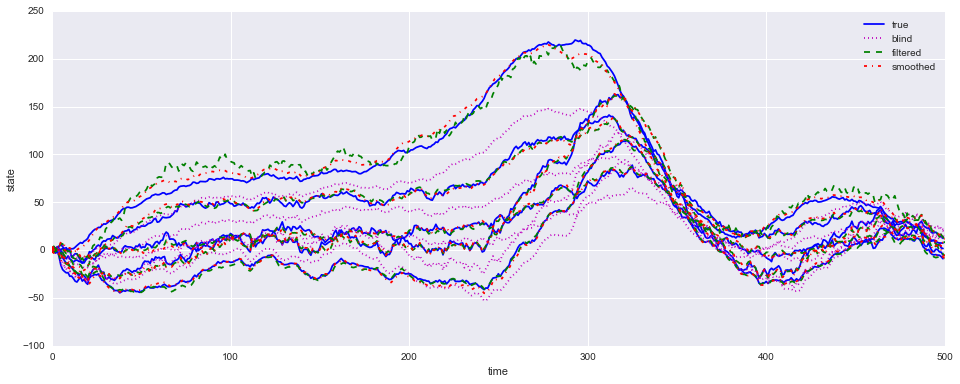

In [20]:
pl.figure(figsize=(16, 6))
lines_true = pl.plot(data.states, linestyle='-', color='b')
lines_blind = pl.plot(blind_state_estimates, linestyle=':', color='m')
lines_filt = pl.plot(filtered_state_estimates, linestyle='--', color='g')
lines_smooth = pl.plot(smoothed_state_estimates, linestyle='-.', color='r')
pl.legend(
    (lines_true[0], lines_blind[0], lines_filt[0], lines_smooth[0]),
    ('true', 'blind', 'filtered', 'smoothed')
)
pl.xlabel('time')
pl.ylabel('state')
pl.xlim(xmax=500)

# Draw log likelihood of observations as a function of EM iteration number.
# Notice how it is increasing (this is guaranteed by the EM algorithm)
pl.show()
